# Data
### Data Selection

In [4]:
import datacq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datacq import STATIONS_METADF
import os
os.environ['PATH'] += ':/Library/TeX/texbin'
stations = ['BETN043', 'BETN063', 'BETR222', 'BETR001', 'BETR802'] # 'BETR802', 'BETROO1', 'BELRL01'
pollutants = ["SO2", "NO2", "CO", "O3", "PM2.5", "PM10"]


target_pol = "PM2.5"

# Read era5 parameters from file
era5_features = datacq.era5.get_params()

# Select time range
startYear = 2013
endYear = 2020
years = range(startYear,endYear+1)

Check types of selected stations

In [5]:
stat_types = {}
for stat in stations:
    typ = STATIONS_METADF.loc[stat]['AirQualityStationType']
    area = STATIONS_METADF.loc[stat]['AirQualityStationArea']
    stat_types[stat] = (typ, area)
    print(f'{stat}: {typ} - {area}')

BETN043: industrial - suburban
BETN063: background - rural
BETR222: background - suburban
BETR001: background - urban
BETR802: traffic - urban


### Data Retrieval

In [6]:
#Retrieve data and construct variable name map ({'u10': '10m_u_component_of_wind',...})
df_dict = {}
var_maps = []
for stat in stations:
    print(f'Retrieving data for {stat}')
    if stat=='BETR802':
        features = [f for f in era5_features if f!='potential_evaporation']
    else:
        features = era5_features
    df_dict[stat], var_map = datacq.get_df(years, stat, features, pollutants, verbose=False)
    var_maps.append(var_map)

# Add nan columns for missing variables
features = set.union(*[set(df_dict[stat].columns) for stat in stations])
for stat in stations:
    missing_features = [f for f in features if f not in df_dict[stat].columns]
    if len(missing_features) > 0:
        print(f'Following features are missing for {stat}: {missing_features}')
        df_dict[stat][missing_features] = np.nan

#Convert to d
df_src = pd.concat(df_dict)
df_src.index.names = ['station', 'time']

#keys = set([key for var_map in var_maps for key in var_map.keys()])
#var_maps_master = {key: list(set([vm[key] for vm in var_maps])) for key in keys}
var_map = var_maps[0]

Retrieving data for BETN043
Retrieving pollution data...
Retrieving ERA5 data...
Retrieving data for BETN063
Retrieving pollution data...
Retrieving ERA5 data...
Retrieving data for BETR222
Retrieving pollution data...
Retrieving ERA5 data...
Retrieving data for BETR001
Retrieving pollution data...
Retrieving ERA5 data...
Retrieving data for BETR802
Retrieving pollution data...
Retrieving ERA5 data...
Following features are missing for BETR802: ['SO2', 'O3', 'pev']


### Preprocessing

In [7]:
import dataprep
import importlib
importlib.reload(dataprep)
df = df_src.copy()
vars_era4 = [v for v in df.columns if v not in pollutants]

df = (df
    .pipe(dataprep.transform_windvars, angle=False)
    .pipe(dataprep.add_aggregates, agg_func='mean')
    .pipe(dataprep.add_aggregates, vars = pollutants, agg_func='max')
    .pipe(dataprep.add_dailyvars)
    .pipe(dataprep.add_weeklyvars)
    .pipe(dataprep.add_yearlyvars)
    .pipe(dataprep.add_workday))

# Targets
# Target PM10 in 24 hours
features_all = list(df)
df['target_point24'] = df[target_pol].shift(-24)
df['target_mean24'] = df[target_pol+'_MA'].shift(-24)

### Train-val-test split

In [8]:
df_trainval = df[df.index.get_level_values('time').year<=2019].copy()
df_test = df[df.index.get_level_values('time').year==2020]

df_path = os.path.join('data','dfs')
if not os.path.exists(df_path):
    os.makedirs(df_path)
df_trainval.to_pickle("data/dfs/df_train.pkl")  
df_test.to_pickle("data/dfs/df_test.pkl")

#Interpolate missing pollutant measurements
print(f"Number of complete training examples: \t{(df_trainval.isna().sum(axis=1)==0).sum()}")
df_trainval[pollutants] = df_trainval[pollutants].interpolate(method='linear', limit=1)
print(f"After interpolation: \t\t\t{(df_trainval.isna().sum(axis=1)==0).sum()}")

Number of complete training examples: 	181061
After interpolation: 			200978


Set columns with more than 15% missing values in eather test or train set to NaN

In [9]:
max_nanrate = 0.2
features_all = [f for f in list(df) if 'target' not in f]
available_features_dict = {}
for stat in stations:
    total_trainval = len(df_trainval.loc[stat])
    nanrates_trainval = df_trainval.loc[stat].isna().sum()/total_trainval
    unavailable_vars_trainval = set(nanrates_trainval[nanrates_trainval > max_nanrate].index.values)

    total_test = len(df_test.loc[stat])
    nanrates_test = df_test.loc[stat].isna().sum()/total_test
    unavailable_vars_test = set(nanrates_test[nanrates_test > max_nanrate].index.values)
    
    unavailable_vars = list(unavailable_vars_trainval|unavailable_vars_test)
    if len(unavailable_vars) > 0:
        print(f'{stat} has {len(unavailable_vars)} unavailable variables: {unavailable_vars}')
        df_trainval.loc[(stat, slice(None)), unavailable_vars] = np.nan
        df_test.loc[(stat, slice(None)), unavailable_vars] = np.nan
    available_features_dict[stat] = list(set(features_all)-set(unavailable_vars))

BETR802 has 8 unavailable variables: ['O3', 'SO2_MAX', 'pev_MA', 'pev', 'SO2', 'O3_MA', 'O3_MAX', 'SO2_MA']


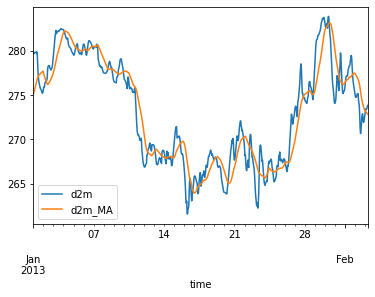

In [10]:
df_stat = df_trainval.loc['BETR802']
df_stat.iloc[:800][['d2m','d2m_MA']].plot()

### Linear trends

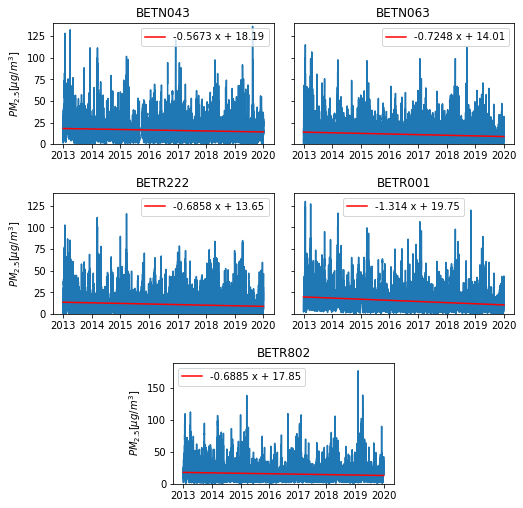

In [11]:
year_in_seconds = 365*24*60*60
nano = 1e9
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(8,8))
axes[2][0].set_visible(False)
axes[2][3].set_visible(False)
locations = [(0,0), (0,2), (1,0), (1,2), (2,1)]


for i,(loc,stat) in enumerate(zip(locations,stations)):
    ax = plt.subplot2grid((3,4), loc, colspan=2)
    nonan_series = df_trainval.loc[stat][target_pol].dropna()
    tt = nonan_series.index.values.astype('int64')/(nano*year_in_seconds)
    tt -= tt[0]
    xx = nonan_series.values
    fit = np.polyfit(tt, xx, 1)
    fit_fn = np.poly1d(fit)
    ax.plot(df_trainval.loc[stat][target_pol])
    ax.plot(nonan_series.index.values, fit_fn(tt), 'r', label=f'{str(fit_fn)[2:]}')
    ax.set_title(stat)
    ax.legend()
    plt.ylim(0,140)
    if i==0 or i==2 or i==4:
        ax.set_ylabel(r'$PM_{2.5} [\mu g/m^3]$')
    else:
        ax.axes.yaxis.set_ticklabels([])
    if i==4:
        plt.ylim(0,190)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.4)
plt.savefig(os.path.join("..","figures",f"trends.png"), 
    facecolor='white', edgecolor='none', bbox_inches='tight', dpi=250)

## Variable selection

In [12]:
features_all = list(df_trainval)
targets = [f for f in features_all if f.startswith('target')]
features_all = [f for f in features_all if f not in targets]
features_MA = [f for f in features_all if f.endswith('_MA')]
features_MAX = [f for f in features_all if f.endswith('_MAX')]
features_lag = [f[:-3] for f in features_MA]
features_time = [f for f in features_all if 
                    f not in features_MAX and
                    f not in features_MA and
                    f not in features_lag]

print(targets)
idx = pd.MultiIndex.from_product([stations, features_all], names=['station', 'Feature'])
FS_results = pd.DataFrame(index=idx)

['target_point24', 'target_mean24']


In [13]:
target = 'target_mean24'

### Crosscorrelations

In [14]:
from scipy.stats import pearsonr
import itertools

Detect if Moving Average (MA) variable is highly correlated with original

In [15]:
FS_results['corr_test'] = True
print(f"Number of candidate features: {len(features_all)}")
correlations = {}
to_delete = []
maxcorr_MA = 0.95
todelete_MA = {}
for stat in stations:
    todelete_MA[stat] = []
    print(f"Station {stat}")
    df_stat = df_trainval.loc[stat]
    for feat in features_all:
        if feat.endswith('_MA'):
            df_select = df_stat[[feat[:-3], feat]].dropna()
            if len(df_select) < 100:
                corr=0
            else:
                corr = pearsonr(df_select[feat[:-3]], df_select[feat])[0]
            if corr>=maxcorr_MA:
                # MA features with high correlation fail the test
                todelete_MA[stat].append(feat)
                FS_results.loc[stat, feat]['corr_test'] = False
                print(f"\t{feat} fails corr_test ({corr})")

Number of candidate features: 69
Station BETN043
Station BETN063
Station BETR222
	d2m_MA fails corr_test (0.9544242698504054)
Station BETR001
	d2m_MA fails corr_test (0.9516401046981787)
Station BETR802


Check all combinations of remaining features for high correlation

In [16]:
intersection_todelete = set.intersection(*[set(s) for s in todelete_MA.values()])
candidates1 = [c for c in features_all if c not in intersection_todelete]
crosscorr_results = {}
for stat in stations:
    print(f'Processing {stat}')
    correlations = {}
    df_stat = df_trainval.loc[stat]
    for feat_a, feat_b in itertools.combinations(candidates1, 2):
        df_select = df_stat[[feat_a, feat_b]].dropna()
        if len(df_select)>1000:
            correlations[(feat_a,feat_b)] = pearsonr(df_select[feat_a], df_select[feat_b])
    df_temp = pd.DataFrame.from_dict(correlations, orient='index')
    df_temp.columns = ['PCC', 'p-value']
    crosscorr_results[stat] = df_temp


Processing BETN043
Processing BETN063
Processing BETR222
Processing BETR001
Processing BETR802


In [17]:
import networkx as nx
maxcorr_all = 0.95
keep = ['t2m', 't2m_MA', 'ssr', 'ssr_MA', 'e', 'e_MA', 'PM10_MA', 'PM2.5_MA', 'ro'] #Keep most sensible features
graphs_long = {}
graphs = {}
for stat in stations:
    result = crosscorr_results[stat]
    #print(result[result.PCC>maxcorr_all].sort_values('PCC', ascending=False).PCC)
    pairs = list(result[result.PCC>maxcorr_all].index)
    pairs_long = []
    for pair in pairs:
        pair_long = ()
        for i,p in enumerate(pair):
            if p in var_map:
                pair_long += (var_map[p],)
            elif p[:-3] in var_map:
                pair_long += (var_map[p[:-3]]+'_MA',)
            else:
                pair_long += (p,)
        pairs_long.append(pair_long) 
    g_long = nx.Graph()    
    g_long.add_edges_from(pairs_long)
    g = nx.Graph()
    g.add_edges_from(pairs)
    graphs_long[stat] = g_long
    graphs[stat] = g
    print(f'Connected sets {stat}:')
    for s in nx.find_cliques(g):
        print(f'\t{s} -> {set(s) & set(keep)}')
    to_delete = [f for f in g.nodes if f not in keep]
    FS_results.loc[(stat,to_delete), 'corr_test'] = False

Connected sets BETN043:
	['ssr', 'ssrd'] -> {'ssr'}
	['ssr_MA', 'ssrd_MA'] -> {'ssr_MA'}
	['slhf_MA', 'e_MA'] -> {'e_MA'}
	['slhf', 'e'] -> {'e'}
Connected sets BETN063:
	['PM2.5_MA', 'PM10_MA'] -> {'PM2.5_MA', 'PM10_MA'}
	['ssr', 'ssrd'] -> {'ssr'}
	['ssr_MA', 'ssrd_MA'] -> {'ssr_MA'}
	['slhf_MA', 'e_MA'] -> {'e_MA'}
	['e', 'evabs'] -> {'e'}
	['e', 'pev'] -> {'e'}
Connected sets BETR222:
	['ssr', 'ssrd'] -> {'ssr'}
	['ssr_MA', 'ssrd_MA'] -> {'ssr_MA'}
	['d2m', 'd2m_MA'] -> set()
	['pev', 'slhf', 'e'] -> {'e'}
	['slhf_MA', 'e_MA'] -> {'e_MA'}
Connected sets BETR001:
	['ssr', 'ssrd'] -> {'ssr'}
	['ssr_MA', 'ssrd_MA'] -> {'ssr_MA'}
	['d2m', 'd2m_MA'] -> set()
	['slhf_MA', 'e_MA'] -> {'e_MA'}
	['slhf', 'e'] -> {'e'}
Connected sets BETR802:
	['ssr', 'ssrd'] -> {'ssr'}
	['ssr_MA', 'ssrd_MA'] -> {'ssr_MA'}
	['slhf_MA', 'e_MA'] -> {'e_MA'}
	['slhf', 'e'] -> {'e'}


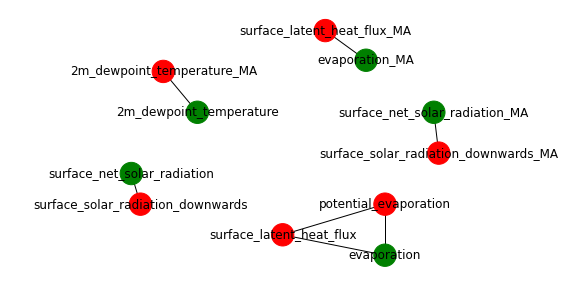

In [18]:
stat = 'BETR222'
g = graphs_long[stat]
color_map = []
keep = ['surface_net_solar_radiation_MA',
        'surface_net_solar_radiation',
        'evaporation_MA',
        'evaporation',
        '2m_dewpoint_temperature']
for node in g:
    if node in keep:
        color_map.append('green')
    else:
        color_map.append('red')

pos=pos = {
    '2m_dewpoint_temperature': [-0.5,  0.4],
    '2m_dewpoint_temperature_MA': [-0.7,  0.8],
    'potential_evaporation': [ 0.6, -0.5 ],
    'evaporation': [ 0.6, -1.0],
    'surface_latent_heat_flux': [-0.0, -0.8],
    'evaporation_MA': [0.48903477, 0.90958606],
    'surface_latent_heat_flux_MA': [0.25, 1.2],
    'surface_net_solar_radiation': [-0.8876729 ,  -0.2],
    'surface_solar_radiation_downwards': [-0.83395751, -0.5],
    'surface_net_solar_radiation_MA': [0.88655746, 0.4],
    'surface_solar_radiation_downwards_MA': [ 0.91529464, -0.0]}
plt.figure(figsize=(10,5))
ax = plt.gca()
nx.draw(g, pos, node_color=color_map, with_labels=True, node_size=500)
ax.set_xlim([1.5*x for x in ax.get_xlim()])
plt.savefig(os.path.join("..","figures",f"corr_graph_{stat}.png"), 
    facecolor='white', edgecolor='none', bbox_inches='tight', dpi=250)
plt.show()

In [19]:
union_corr_fail = set(FS_results[~FS_results['corr_test']].index.get_level_values(1).values)
inters_corr_fail = set.intersection(
                        *[set(FS_results.loc[stat][FS_results.loc[stat].corr_test==False]
                            .index.values)
                        for stat in stations])
print(f'Intersection of features that failed the correlation test ({len(inters_corr_fail)} total):\n\t'
            f'{inters_corr_fail}')
for stat in stations:
    corr_failed_stat = [f for f in features_all if not FS_results.loc[stat, f]['corr_test']]
    other_failed_stat = set(corr_failed_stat)-inters_corr_fail
    if other_failed_stat:
        print(f'Extra failed features for {stat}: {other_failed_stat}')


Intersection of features that failed the correlation test (3 total):
	{'ssrd', 'ssrd_MA', 'slhf_MA'}
Extra failed features for BETN043: {'slhf'}
Extra failed features for BETN063: {'evabs', 'pev'}
Extra failed features for BETR222: {'slhf', 'd2m_MA', 'pev', 'd2m'}
Extra failed features for BETR001: {'slhf', 'd2m_MA', 'd2m'}
Extra failed features for BETR802: {'slhf'}


In [20]:
remaining_features = [f for f in features_all if f not in inters_corr_fail]
print(f'Remaining features ({len(remaining_features)} total): \n\t', remaining_features)

Remaining features (66 total): 
	 ['SO2', 'SO2_MAX', 'SO2_MA', 'NO2', 'NO2_MAX', 'NO2_MA', 'CO', 'CO_MAX', 'CO_MA', 'O3', 'O3_MAX', 'O3_MA', 'PM2.5', 'PM2.5_MAX', 'PM2.5_MA', 'PM10', 'PM10_MAX', 'PM10_MA', 'd2m', 'd2m_MA', 't2m', 't2m_MA', 'evabs', 'evabs_MA', 'pev', 'pev_MA', 'ro', 'ro_MA', 'e', 'e_MA', 'slhf', 'ssr', 'ssr_MA', 'str', 'str_MA', 'sp', 'sp_MA', 'sshf', 'sshf_MA', 'strd', 'strd_MA', 'tp', 'tp_MA', 'blh', 'blh_MA', 'lcc', 'lcc_MA', 'hcc', 'hcc_MA', 'mcc', 'mcc_MA', 'tcc', 'tcc_MA', 'w_speed', 'w_speed_MA', 'w_dir_sin', 'w_dir_sin_MA', 'w_dir_cos', 'w_dir_cos_MA', 'daily_sin', 'daily_cos', 'weekly_sin', 'weekly_cos', 'yearly_sin', 'yearly_cos', 'workday']


### Detecting noisy features

In [21]:
from featexp import get_trend_stats
FS_results['val_corr'] = -1
trends = {}
train_df = df_trainval[df_trainval.index.get_level_values('time').year<2018]
val_df = df_trainval[df_trainval.index.get_level_values('time').year>=2018]
for stat in stations:
    print(f'Processing {stat}')
    res = get_trend_stats(data=train_df.loc[(stat, slice(None)),available_features_dict[stat]+[target]],
                            target_col=target, 
                            data_test=val_df.loc[stat].copy())
    res.set_index('Feature', inplace=True)
    FS_results.loc[(stat, res.Trend_correlation.index),'val_corr'] = res.Trend_correlation.values
    trends[stat] = res

Processing BETN043
Returning stats for all numeric features
Processing BETN063
Returning stats for all numeric features
Processing BETR222
Returning stats for all numeric features
Processing BETR001
Returning stats for all numeric features
Processing BETR802
Returning stats for all numeric features


In [22]:
threshold_noise = 0.9
noisy_sets = {stat:set(FS_results[FS_results.val_corr<threshold_noise].loc[stat].index.values)
                    for stat in stations}
noisy_intersection = set.intersection(*[noisy_sets[stat] for stat in stations])
print('Intersection: ', noisy_intersection)
for stat in stations:
    print(f'Extra for {stat}: {noisy_sets[stat]-noisy_intersection}')


Intersection:  {'ssr', 'daily_cos', 'ssr_MA', 'weekly_sin', 'yearly_cos', 'evabs_MA', 'ro_MA', 'ro', 'SO2_MAX', 'ssrd_MA', 'yearly_sin', 'evabs', 'SO2', 'str_MA', 'SO2_MA', 'str', 'daily_sin'}
Extra for BETN043: {'hcc_MA', 'CO_MA', 'sp_MA', 'sp', 'ssrd', 'weekly_cos', 'CO_MAX', 'lcc_MA', 't2m_MA', 'CO', 'hcc'}
Extra for BETN063: {'tcc_MA', 'sp_MA', 'sp', 'ssrd', 'pev_MA', 'weekly_cos', 'slhf_MA', 'lcc_MA', 'hcc', 'e_MA'}
Extra for BETR222: {'hcc_MA', 'tcc_MA', 'tp_MA', 'pev_MA', 'weekly_cos', 'slhf_MA', 'lcc_MA', 'e_MA'}
Extra for BETR001: {'CO_MA', 'sp_MA', 'sp', 'ssrd', 'pev_MA', 'weekly_cos', 'pev', 'slhf_MA', 'hcc', 'd2m_MA', 'lcc_MA', 't2m_MA', 'O3_MAX', 'e_MA', 'workday'}
Extra for BETR802: {'hcc_MA', 'O3', 'sp_MA', 'sp', 'ssrd', 'pev_MA', 'pev', 'slhf_MA', 'slhf', 'hcc', 'e', 'O3_MA', 'O3_MAX', 'e_MA', 'lcc'}


In [23]:
noisy_era5 = [f for f in noisy_intersection if any(f.startswith(var) for var in list(var_map.keys()))]
noisy_pollutants = [f for f in noisy_intersection if any(f.startswith(pol) for pol in pollutants)]
noisy_time = noisy_intersection-set(noisy_era5)-set(noisy_pollutants)


print(f'Noisy era5 features: {sorted(noisy_era5)}')
print([var_map[f] for f in noisy_era5 if '_MA' not in f])
print(f'Noisy pollutants: {sorted(noisy_pollutants)}')
print(f'Noisy temporal features: {sorted(noisy_time)}')


Noisy era5 features: ['evabs', 'evabs_MA', 'ro', 'ro_MA', 'ssr', 'ssr_MA', 'ssrd_MA', 'str', 'str_MA']
['surface_net_solar_radiation', 'runoff', 'evaporation_from_bare_soil', 'surface_net_thermal_radiation']
Noisy pollutants: ['SO2', 'SO2_MA', 'SO2_MAX']
Noisy temporal features: ['daily_cos', 'daily_sin', 'weekly_sin', 'yearly_cos', 'yearly_sin']


In [24]:
to_delete = sorted(noisy_era5)+['daily_sin', 'daily_cos']
final_candidates = [c for c in features_all if c not in to_delete and c not in inters_corr_fail]
print(f'Deleted variables ({len(to_delete)} total): ', to_delete)
print(f'{len(final_candidates)} candidates left')

Deleted variables (11 total):  ['evabs', 'evabs_MA', 'ro', 'ro_MA', 'ssr', 'ssr_MA', 'ssrd_MA', 'str', 'str_MA', 'daily_sin', 'daily_cos']
56 candidates left


['BETN043', 'BETN063', 'BETR222', 'BETR001', 'BETR802']
                                           Plots for PM2.5                                            
                                           Train data plots                                           


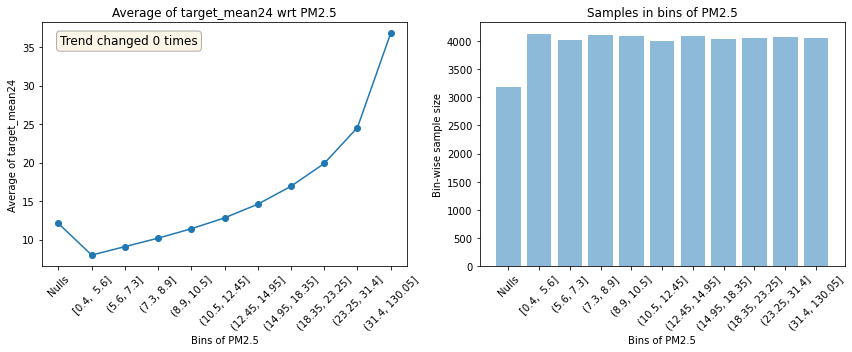

                                           Test data plots                                            


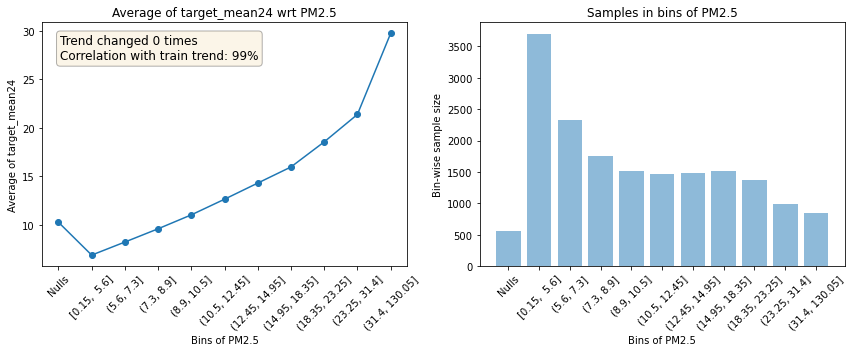

--------------------------------------------------------------------------------------------------------------




In [25]:
from featexp import univariate_plotter
print(stations)
feat = 'PM2.5'
stat = 'BETR001'
feat_train = train_df.loc[stat,[feat,target]]
feat_val = val_df.loc[stat,[feat,target]]
binned_data_train, binned_data_test = (
    univariate_plotter(data=feat_train.copy(),
                     target_col=target,
                     feature=feat,
                     data_test=feat_val))

### Boruta

In [28]:
from BorutaShap import BorutaShap
print('Number of features: ', len(final_candidates))
pvalue = 0.05

eval_hours = [11,23]
sample_frac = 1

n_trials = 100
percentile = 100
sample = False

Number of features:  56


In [29]:
importance_measures = ['shap']
selectors = {}
for stat in stations:
    selectors[stat] = {}
    df_stat = df_trainval.loc[stat]
    for h in eval_hours:
        selectors[stat][h] = {}
        df_temp = df_stat[df_stat.index.hour==h]
        candidates = [f for f in final_candidates if f in available_features_dict[stat]]
        df_temp = (df_temp[candidates+[target]]
                            .dropna()
                            .sample(frac=sample_frac))
        X = df_temp[candidates]
        y = df_temp[target]
        for im in importance_measures:
            boruta_im_h = f'boruta_{im}_{h}'
            FS_results.loc[stat][boruta_im_h] = None
            
            print(f"\t # Training examples: {len(X)}")
            Feature_Selector = BorutaShap(importance_measure=im,
                                    classification=False, pvalue=pvalue,
                                    percentile=percentile)
            Feature_Selector.fit(X=X, y=y, n_trials=n_trials, sample=sample,
                train_or_test = 'test', normalize=True,
                verbose=True)
            FS_results.loc[(stat,Feature_Selector.accepted), boruta_im_h] = 1
            FS_results.loc[(stat,Feature_Selector.rejected), boruta_im_h] = -1
            FS_results.loc[(stat,Feature_Selector.tentative), boruta_im_h] = 0
            selectors[stat][h][im] = Feature_Selector
    
    file_name = f'FS_results_{stat}_'+'_'.join(sorted(importance_measures))
    if sample:
        file_name += '_sample'
    FS_results.loc[stat].to_csv(os.path.join('data','FS_results',f'{file_name}.csv'))

	 # Training examples: 1933


  0%|          | 0/100 [00:00<?, ?it/s]

Trial 11, 11 features confirmed important: ['PM2.5_MA', 'w_dir_cos', 'PM2.5_MAX', 'yearly_cos', 'sp', 'yearly_sin', 'w_dir_cos_MA', 'blh', 'PM2.5', 'w_speed', 'strd']
Trial 13, 13 features confirmed important: ['PM2.5_MA', 'w_dir_cos', 'PM2.5_MAX', 'sp_MA', 'yearly_cos', 'sp', 'yearly_sin', 'w_dir_cos_MA', 'blh', 'PM2.5', 'd2m_MA', 'w_speed', 'strd']
Trial 16, 14 features confirmed important: ['PM2.5_MA', 'w_dir_cos', 'PM2.5_MAX', 'sp_MA', 'yearly_cos', 'sp', 'yearly_sin', 'w_dir_cos_MA', 'blh', 'PM2.5', 'mcc_MA', 'd2m_MA', 'w_speed', 'strd']
Trial 22, 16 features confirmed important: ['PM2.5_MA', 'w_dir_cos', 'PM2.5_MAX', 'sp_MA', 'yearly_cos', 'd2m', 'sp', 'yearly_sin', 'w_dir_cos_MA', 'blh', 'PM2.5', 'mcc_MA', 'd2m_MA', 't2m_MA', 'w_speed', 'strd']
Trial 33, 17 features confirmed important: ['PM2.5_MA', 'w_dir_cos', 'PM2.5_MAX', 'sp_MA', 'yearly_cos', 'd2m', 'sp', 'yearly_sin', 'w_dir_cos_MA', 'blh', 'PM2.5', 'mcc_MA', 'd2m_MA', 't2m_MA', 'w_speed', 'e_MA', 'strd']
Trial 46, 18 feat

  0%|          | 0/100 [00:00<?, ?it/s]

In [48]:
FS_results

corr_test  val_corr boruta_shap_11 boruta_gini_11  \
station Feature                                                         
BETN043 SO2              True  0.614415             -1             -1   
        SO2_MAX          True  0.790214             -1             -1   
        SO2_MA           True  0.425638             -1             -1   
        NO2              True  0.973534             -1             -1   
        NO2_MAX          True  0.916899             -1             -1   
...                       ...       ...            ...            ...   
BETR001 weekly_sin       True -0.951904             -1             -1   
        weekly_cos       True -0.966285             -1             -1   
        yearly_sin       True  0.833895              1             -1   
        yearly_cos       True  0.400657             -1             -1   
        workday          True -1.000000             -1             -1   

                   boruta_shap_23 boruta_gini_23  
station Feature                                   
BETN043 SO2                    -1             -1  
        SO2_MAX                -1             -1  
        SO2_MA                 -1             -1  
        NO2                    -1             -1  
        NO2_MAX                -1             -1  
...                           ...            ...  
BETR001 weekly_sin              0             -1  
        weekly_cos             -1             -1  
        yearly_sin             -1             -1  
        yearly_cos             -1             -1  
        workday                -1             -1  

[276 rows x 6 columns]

In [49]:
file_name = 'FS_results'+'_'.join(sorted(importance_measures))
if sample:
    file_name += '_sample'
FS_results.to_csv(os.path.join('data',f'{file_name}.csv'))

In [ ]:
for stat in stations:
    shap_success = set([f for f in final_candidates if FS_results.loc[stat,f]['boruta_shap_23']==1])
    gini_success = set([f for f in final_candidates if FS_results.loc[stat,f]['boruta_gini_23']==1])
    both_success = shap_success & gini_success
    print(f'Stations {stat}:')
    print(f'Both successfull: {both_success}')
    print(f'Only Shap: {shap_success-both_success}')
    print(f'Only Gini: {gini_success-both_success}')
    print()


NameError: name 'stations' is not defined